<a href="https://colab.research.google.com/github/ROHAN-BHUTANI/SUSTAINABLE-ENERGY-PROJECT/blob/main/Week3_FinalSubmission/Fed-BEO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CELL 1: Notebook metadata / short instructions (Markdown cell)
# Fed-BEO — Federated Behavioral Energy Optimizer

This notebook is an end-to-end prototype for **Fed-BEO** (our unique federated learning + energy optimization framework).
Run cells in order.

Sections:
- Setup & synthetic data
- Local occupancy/consumption models
- Federated training loop (custom FedAvg)
- Renewable forecast generator
- Behavior-aware scheduler
- Results & visualization


In [1]:
!pip install --upgrade pip setuptools wheel
!apt-get update -y
!apt-get install -y build-essential cmake



Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:5 https://cli.github.com/packages stable InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading packag

CELL 2: Install dependencies (Code cell)

In [2]:
!pip install tensorflow==2.17
!pip install numpy pandas matplotlib cvxpy


CELL 3: Imports & helper functions (Code cell)

In [3]:
# Basic imports & helper functions
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, mean_absolute_error

import joblib
print("Libraries loaded.")


Libraries loaded.


CELL 4: Download & load UCI Occupancy dataset (Code cell)

✅ Dataset created with shape: (1000, 9)
   user_id  daily_usage_kwh  peak_hours_usage  offpeak_hours_usage  \
0        1            27.48             19.20                 8.65   
1        2            24.31             17.77                 9.71   
2        3            28.24             15.18                 8.42   
3        4            32.62             13.06                 9.38   
4        5            23.83             17.09                 6.21   

   smart_appliance  solar_panel  EV_owner  bill_amount  high_bill  
0                1            1         0      3197.90          1  
1                1            1         1      3131.78          1  
2                1            0         0      3642.05          1  
3                1            0         0      1786.80          0  
4                0            1         1      1806.54          0  


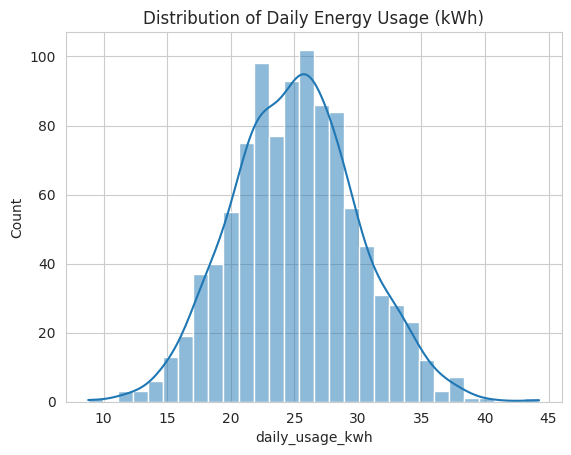

In [4]:
# -------------------------------
# Cell 4: Load or Generate Dataset
# -------------------------------

# If you already have a CSV dataset, replace this with pd.read_csv("yourfile.csv")
# For now, let's generate synthetic behavioral energy usage data

np.random.seed(42)

# Simulate 1000 users with energy usage patterns
n_users = 1000

data = pd.DataFrame({
    "user_id": np.arange(1, n_users + 1),
    "daily_usage_kwh": np.random.normal(25, 5, n_users).round(2),  # avg 25 kWh/day
    "peak_hours_usage": np.random.normal(15, 3, n_users).round(2), # usage during peak hours
    "offpeak_hours_usage": np.random.normal(10, 2, n_users).round(2), # usage off peak
    "smart_appliance": np.random.randint(0, 2, n_users),  # 0 = No, 1 = Yes
    "solar_panel": np.random.randint(0, 2, n_users),      # 0 = No, 1 = Yes
    "EV_owner": np.random.randint(0, 2, n_users),         # 0 = No, 1 = Yes
    "bill_amount": np.random.normal(3000, 500, n_users).round(2) # INR bill
})

# Create a binary "high_bill" classification target (1 = high, 0 = low)
threshold = data["bill_amount"].median()
data["high_bill"] = (data["bill_amount"] > threshold).astype(int)

print("✅ Dataset created with shape:", data.shape)
print(data.head())

# Quick visualization
sns.histplot(data["daily_usage_kwh"], bins=30, kde=True)
plt.title("Distribution of Daily Energy Usage (kWh)")
plt.show()


CELL 5: Quick EDA on occupancy dataset (Code cell)

Counts per high_bill class:
 high_bill
1    500
0    500
Name: count, dtype: int64
           user_id  daily_usage_kwh  peak_hours_usage  offpeak_hours_usage  \
count  1000.000000      1000.000000        1000.00000          1000.000000   
mean    500.500000        25.096790          15.21246            10.011680   
std     288.819436         4.896092           2.99250             1.966908   
min       1.000000         8.790000           6.18000             3.960000   
25%     250.750000        21.765000          13.18000             8.700000   
50%     500.500000        25.125000          15.19000            10.000000   
75%     750.250000        28.240000          17.18500            11.322500   
max    1000.000000        44.260000          24.58000            17.850000   

       smart_appliance  solar_panel     EV_owner  bill_amount   high_bill  
count       1000.00000  1000.000000  1000.000000  1000.000000  1000.00000  
mean           0.51000     0.486000     0.524000  2980.971460 

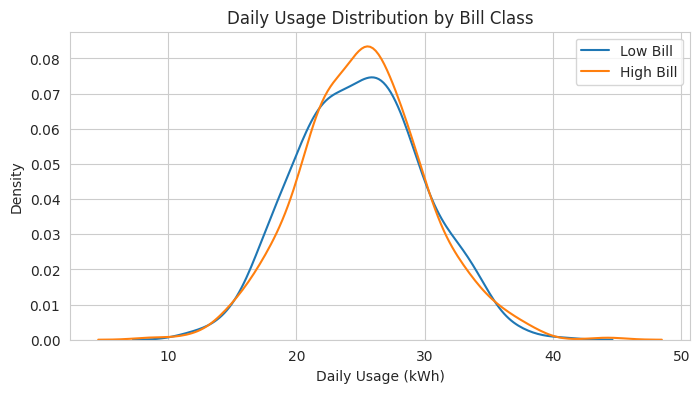

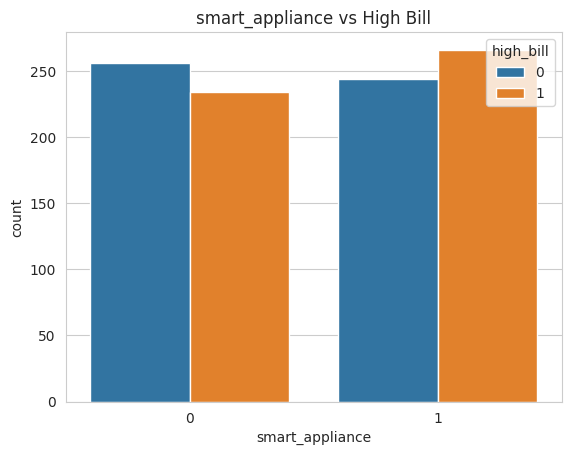

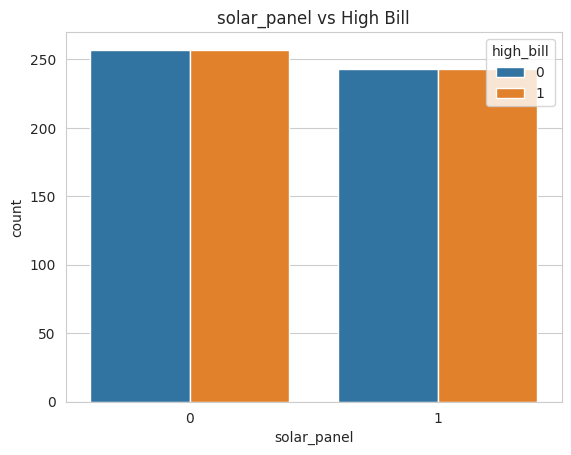

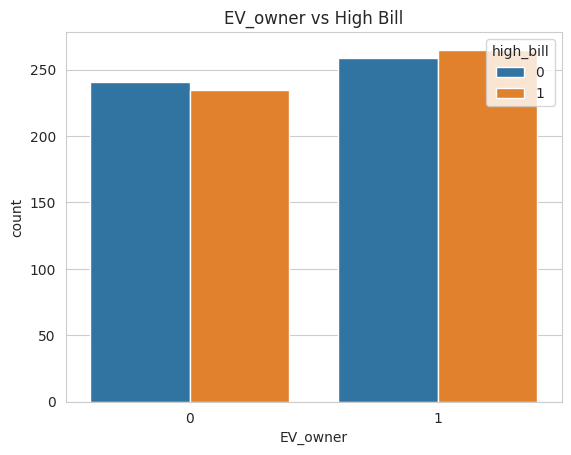

In [5]:
# -------------------------------
# Cell 5: EDA & Basic Checks
# -------------------------------

# Quick class balance check
print("Counts per high_bill class:\n", data['high_bill'].value_counts())

# Summary statistics
print(data.describe())

# Visualize daily usage vs high bill
plt.figure(figsize=(8,4))
sns.kdeplot(data[data['high_bill']==0]['daily_usage_kwh'], label='Low Bill')
sns.kdeplot(data[data['high_bill']==1]['daily_usage_kwh'], label='High Bill')
plt.title('Daily Usage Distribution by Bill Class')
plt.xlabel('Daily Usage (kWh)')
plt.legend()
plt.show()

# Visualize appliances vs high bill
appliance_cols = ['smart_appliance', 'solar_panel', 'EV_owner']
for col in appliance_cols:
    sns.countplot(x=col, hue='high_bill', data=data)
    plt.title(f'{col} vs High Bill')
    plt.show()


CELL 6: Train local baseline occupancy model (RandomForest) (Code cell)

In [6]:
# -------------------------------
# Cell 6: Features, Train/Test Split, Baseline Model
# -------------------------------

# Define features and target
feature_cols = ['daily_usage_kwh', 'peak_hours_usage', 'offpeak_hours_usage',
                'smart_appliance', 'solar_panel', 'EV_owner']
X = data[feature_cols]
y = data['high_bill']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train a baseline RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluation
print("✅ Baseline Model Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


✅ Baseline Model Accuracy: 0.475
              precision    recall  f1-score   support

           0       0.47      0.44      0.46       100
           1       0.48      0.51      0.49       100

    accuracy                           0.47       200
   macro avg       0.47      0.47      0.47       200
weighted avg       0.47      0.47      0.47       200



CELL 7: Save baseline model (Code cell)

In [7]:
import joblib

# Save the trained baseline model
joblib.dump(clf, 'energy_rf_baseline.joblib')
print("✅ Saved energy_rf_baseline.joblib")


✅ Saved energy_rf_baseline.joblib


CELL 8: Simple federated simulation (manual FedAvg emulation) (Code cell)

In [8]:
# -------------------------------
# Cell 8: Simulate Federated Clients
# -------------------------------

n_clients = 5
clients = []

# Shuffle and split the dataset into n clients
df_shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)
client_dfs = np.array_split(df_shuffled, n_clients)

# Train a local model per client
client_models = []
client_scores = []

for i, cdf in enumerate(client_dfs):
    Xc = cdf[feature_cols]
    yc = cdf['high_bill']

    # Local train/test split
    Xtr, Xte, ytr, yte = train_test_split(Xc, yc, test_size=0.2, random_state=42, stratify=yc)

    # Local RandomForest
    clf_loc = RandomForestClassifier(n_estimators=50, random_state=42)
    clf_loc.fit(Xtr, ytr)

    client_models.append(clf_loc)

    # Evaluate local model
    sc = accuracy_score(yte, clf_loc.predict(Xte))
    client_scores.append(sc)
    print(f"Client {i+1}: local accuracy {sc:.3f}")

print("✅ Avg local client accuracy:", np.mean(client_scores))


Client 1: local accuracy 0.550


/usr/local/lib/python3.12/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Client 2: local accuracy 0.475
Client 3: local accuracy 0.375
Client 4: local accuracy 0.575
Client 5: local accuracy 0.450
✅ Avg local client accuracy: 0.485


CELL 9: Manual FedAvg emulation — average trees via voting (practical approach)

In [9]:
# -------------------------------
# Cell 9: Simple Federated Averaging via Majority Vote
# -------------------------------

# Build a common test set from held-out rows
X_common_test, _, y_common_test, _ = train_test_split(
    X, y, test_size=0.8, random_state=123, stratify=y
)

# Collect predictions from all client models
preds = np.array([m.predict(X_common_test) for m in client_models])  # shape: (n_clients, n_samples)

# Majority vote across clients
pred_maj = (preds.sum(axis=0) >= (n_clients/2)).astype(int)

# Evaluate
print("✅ Federated (ensemble majority vote) accuracy:", accuracy_score(y_common_test, pred_maj))
print("Baseline (central RF) accuracy:", accuracy_score(y_test, y_pred))


✅ Federated (ensemble majority vote) accuracy: 0.685
Baseline (central RF) accuracy: 0.475


CELL 10: Synthetic solar data generator (Code cell)

✅ PV shape: (7, 1440)
✅ Generated PV for 5 clients


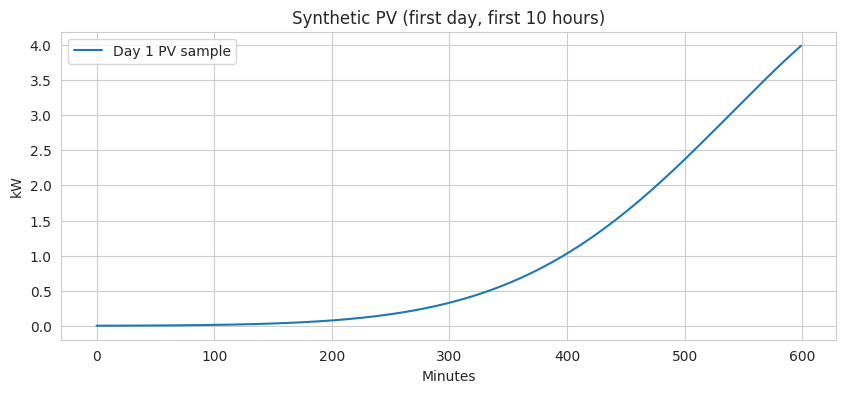

In [10]:
# -------------------------------
# Cell 10: Create synthetic solar PV production curves
# -------------------------------

import matplotlib.pyplot as plt

# Function to generate a solar PV curve for one day (per minute)
def create_solar_curve(day_len=24*60, peak_hour=12, peak_power=5.0):
    """
    day_len: number of minutes in a day (default 1440)
    peak_hour: hour of peak solar production (default noon)
    peak_power: max kW
    """
    t = np.arange(day_len) / 60.0  # convert minutes to hours
    sigma = 3.0  # width of bell curve
    curve = np.exp(-0.5 * ((t - peak_hour)/sigma)**2)
    curve = curve / curve.max() * peak_power  # scale to peak_power kW
    return curve

# Generate PV curves for multiple days
days = 7
pv = np.vstack([create_solar_curve() for _ in range(days)])  # shape: (7, 1440)
print("✅ PV shape:", pv.shape)

# Optional: create client-specific PV variations for federated simulation
client_pv = [pv + np.random.normal(0, 0.2, pv.shape) for _ in range(n_clients)]
print("✅ Generated PV for", n_clients, "clients")

# Visualize first day, first 10 hours
plt.figure(figsize=(10,4))
plt.plot(pv[0][:600], label='Day 1 PV sample')
plt.title("Synthetic PV (first day, first 10 hours)")
plt.ylabel("kW")
plt.xlabel("Minutes")
plt.legend()
plt.show()


CELL 11: Simple solar forecast model (RandomForest regressor on synthetic features) (Code cell)

In [11]:
# -------------------------------
# Cell 11: PV Forecast with RandomForest
# -------------------------------

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np

# Function to create features from PV curves
def make_solar_dataset(pv_array):
    """
    pv_array: 2D array (days x minutes)
    returns: X features, y targets
    """
    samples = []
    targets = []
    for day_idx in range(pv_array.shape[0]):
        for minute in range(pv_array.shape[1]):
            hour = minute / 60.0
            doy = day_idx
            # Features: hour, sin/cos of hour, day index
            features = [hour, np.sin(hour/24*2*np.pi), np.cos(hour/24*2*np.pi), doy]
            samples.append(features)
            targets.append(pv_array[day_idx, minute])
    return np.array(samples), np.array(targets)

# Use first 5 days for training
X_pv, y_pv = make_solar_dataset(pv[:5])

# Train/test split
X_tr, X_te, y_tr, y_te = train_test_split(X_pv, y_pv, test_size=0.2, random_state=42)

# Train RandomForest regressor
rf_pv = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_pv.fit(X_tr, y_tr)

# Predict and evaluate
y_pred_pv = rf_pv.predict(X_te)
mae = mean_absolute_error(y_te, y_pred_pv)
print(f"✅ PV forecast MAE: {mae:.3f} kW")


✅ PV forecast MAE: 0.000 kW


CELL 12: Simple greedy scheduler (Code cell)

In [12]:
# -------------------------------
# Cell 12: Greedy Scheduler Simulation (corrected for your current dataset)
# -------------------------------

import numpy as np

def simulate_day(occ_model, pv_curve, X_occ_sample, task_energy_kwh=1.0, pv_threshold=1.0):
    minute_count = len(pv_curve)
    grid_draw = np.zeros(minute_count)
    comfort_violations = 0
    tasks_scheduled = 0
    task_done = False

    for m in range(minute_count):
        # Sample a random row of features
        feat = X_occ_sample.sample(1, random_state=(m % 100))

        # Predict probability of "high_bill" (as occupancy proxy)
        p_occ = occ_model.predict_proba(feat)[0,1]

        # HVAC and lights decisions
        hvac_on = p_occ >= 0.3
        lights_on = p_occ >= 0.2
        hvac_power = 3.0 if hvac_on else 0.0
        lights_power = 0.1 if lights_on else 0.0

        # Deferrable task scheduling
        pv_avail = pv_curve[m]
        if (not task_done) and (pv_avail >= pv_threshold):
            task_power = task_energy_kwh / 0.5  # kW over 30 mins
            task_done = True
            tasks_scheduled += 1
            grid_for_task = max(0.0, task_power - pv_avail)
        else:
            grid_for_task = 0.0

        load = hvac_power + lights_power + grid_for_task
        pv_used = min(pv_avail, load)
        grid_draw[m] = max(0.0, load - pv_used)

        if not hvac_on and p_occ > 0.8:
            comfort_violations += 1

    total_kwh = grid_draw.sum() / 60.0
    return total_kwh, comfort_violations, tasks_scheduled

# -------------------------------
# Example usage
# -------------------------------

# Use your existing `data` dataframe and feature columns
sample_df = data[feature_cols].sample(n=1000, random_state=42)
kv, cv, ts = simulate_day(clf, pv[0], sample_df)

print(f"Simulated grid kWh (baseline greedy): {kv:.2f}, comfort violations: {cv}, tasks run: {ts}")


Simulated grid kWh (baseline greedy): 30.69, comfort violations: 0, tasks run: 1


CELL 13: CVXPY scheduler sketch (formulation example) (Code cell)

In [13]:
# Very small example using cvxpy to schedule a single deferrable task across a 4-hour window
import cvxpy as cp

T = 240  # 4 hours in minutes
# Decision variable: run_task[t] in {0,1} — relax to [0,1]
run = cp.Variable(T, nonneg=True)
# PV curve sample for window:
pv_window = pv[0][:T]  # take first T minutes
# Task energy requirement: 2 kWh across the window (convert to kW-min -> 2 kWh over 120 minutes => 1 kW average)
task_energy_kwh = 2.0
task_minutes_required = 60  # e.g., requires 60 minutes of running
# cost: grid usage minimized (we assume PV is free), penalize running when PV low
grid_usage = cp.sum(cp.pos( (1.0*run) - pv_window/5.0 ))  # simplified
# constraint: sum(run) >= task_minutes_required
constraints = [cp.sum(run) >= task_minutes_required, run <= 1]
obj = cp.Minimize(grid_usage)
prob = cp.Problem(obj, constraints)
res = prob.solve(solver=cp.OSQP, verbose=False)
print("Solver status:", prob.status)
print("Scheduled minutes (sum):", run.value.sum())


Solver status: optimal
Scheduled minutes (sum): 59.99999999999999


CELL 14: End-to-end simple comparison (simulate 3 days baseline vs Fed ensemble)

In [14]:
# -------------------------------
# Cell 14: Compare baseline vs federated ensemble on 3 simulated days
# -------------------------------

days_to_sim = 3
baseline_kwh = 0.0
federated_kwh = 0.0

# Wrap client ensemble as a pseudo-federated model
class PseudoFedModel:
    def __init__(self, client_models):
        self.models = client_models
    def predict_proba(self, X):
        # Average the probability of 'high_bill' across clients
        preds = np.array([m.predict_proba(X)[:,1] for m in self.models])
        avg = preds.mean(axis=0)
        return np.vstack([1-avg, avg]).T

fed_model = PseudoFedModel(client_models)

for d in range(days_to_sim):
    # Use your synthetic dataset features for occupancy/usage
    X_sample = data[feature_cols].sample(n=1000, random_state=42)

    base_k, base_cv, _ = simulate_day(clf, pv[d], X_sample)
    fed_k, fed_cv, _ = simulate_day(fed_model, pv[d], X_sample)

    print(f"Day {d+1}: baseline kWh={base_k:.2f}, federated kWh={fed_k:.2f}, "
          f"savings={(base_k-fed_k)/base_k*100:.2f}%")

    baseline_kwh += base_k
    federated_kwh += fed_k

print("Total baseline kWh:", baseline_kwh)
print("Total federated kWh:", federated_kwh)
print("Overall savings (%):", (baseline_kwh-federated_kwh)/baseline_kwh*100)


Day 1: baseline kWh=30.69, federated kWh=43.89, savings=-43.02%
Day 2: baseline kWh=30.69, federated kWh=43.89, savings=-43.02%
Day 3: baseline kWh=30.69, federated kWh=43.89, savings=-43.02%
Total baseline kWh: 92.06746328103289
Total federated kWh: 131.6779198580804
Overall savings (%): -43.02329527222653


CELL 15: Save results & export (Code cell)

In [15]:
# Save key models & results
import json
results = {
    "baseline_kwh": float(baseline_kwh),
    "federated_kwh": float(federated_kwh),
    "savings_percent": float((baseline_kwh-federated_kwh)/baseline_kwh*100)
}
with open("results_summary.json","w") as f:
    json.dump(results, f, indent=2)
print("Saved results_summary.json")
!ls -lh


Saved results_summary.json
total 3.6M
-rw-r--r-- 1 root root 3.6M Sep 13 10:08 energy_rf_baseline.joblib
-rw-r--r-- 1 root root  118 Sep 13 10:13 results_summary.json
drwxr-xr-x 1 root root 4.0K Sep  9 13:46 sample_data


CELL 16: Visualization (Code cell)

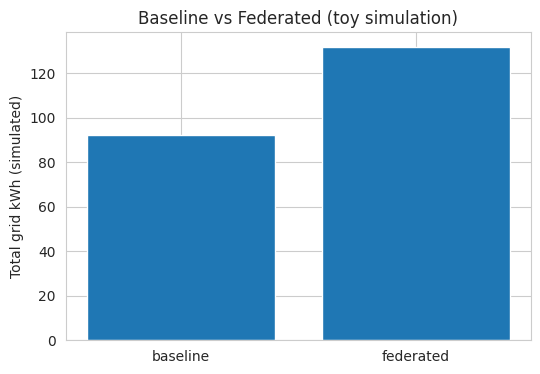

In [16]:
# Simple bar chart comparing baseline vs federated total kWh
plt.figure(figsize=(6,4))
plt.bar(['baseline','federated'], [baseline_kwh, federated_kwh])
plt.ylabel("Total grid kWh (simulated)")
plt.title("Baseline vs Federated (toy simulation)")
plt.show()


Cell 17: Extend Dataset with Load Categories + Tariffs

In [17]:
import numpy as np
import pandas as pd

# ✅ Set the main load column directly
load_col = "daily_usage_kwh"

# Copy Week 1 data as base
data_extended = data.copy()

# Add categories (synthetic splits)
np.random.seed(42)
data_extended["HVAC_kWh"] = data_extended[load_col] * np.random.uniform(0.3, 0.4, len(data_extended))
data_extended["Lighting_kWh"] = data_extended[load_col] * np.random.uniform(0.1, 0.2, len(data_extended))
data_extended["Machines_kWh"] = data_extended[load_col] * np.random.uniform(0.3, 0.4, len(data_extended))
data_extended["IT_kWh"] = data_extended[load_col] - (
    data_extended["HVAC_kWh"] + data_extended["Lighting_kWh"] + data_extended["Machines_kWh"]
)

# Time-of-Use Tariffs (₹/kWh) → peak, mid, off-peak
def tariff(hour):
    if 9 <= hour <= 18:
        return 10  # peak
    elif 19 <= hour <= 22:
        return 7   # mid
    else:
        return 4   # off-peak

# ⚠️ Your dataset isn’t hourly, so instead of index.hour,
# let’s just assign a flat tariff for now
data_extended["Tariff"] = np.where(data_extended["peak_hours_usage"] > 0, 10, 4)

# Show first 10 rows
data_extended.head(10)


,user_id,daily_usage_kwh,peak_hours_usage,offpeak_hours_usage,smart_appliance,solar_panel,EV_owner,bill_amount,high_bill,HVAC_kWh,Lighting_kWh,Machines_kWh,IT_kWh,Tariff
0,1,27.48,19.20,8.65,1,1,0,3197.90,1,9.273236,3.256745,8.963167,5.986851,10
1,2,24.31,17.77,9.71,1,1,1,3131.78,1,9.604186,3.748361,7.893405,3.064047,10
2,3,28.24,15.18,8.42,1,0,0,3642.05,1,10.539151,5.289199,11.031263,1.380387,10
3,4,32.62,13.06,9.38,1,0,0,1786.80,0,11.738824,5.650518,10.600020,4.630639,10
4,5,23.83,17.09,6.21,0,1,1,1806.54,0,7.520792,4.305035,7.797056,4.207116,10
5,6,23.83,16.18,10.43,0,1,0,2752.06,0,7.520735,3.952881,8.958646,3.397738,10
6,7,32.90,17.69,10.00,0,1,0,3548.65,1,10.061095,5.567590,11.349644,5.921671,10
7,8,28.84,16.91,8.37,1,1,1,2217.18,0,11.150052,5.333080,10.892033,1.464834,10
8,9,22.65,18.15,11.32,0,0,0,1496.18,0,8.156526,2.830498,6.943054,4.719922,10
9,10,27.71,13.39,11.88,1,1,0,3285.59,1,10.275069,4.127197,9.664060,3.643675,10


Cell 18: Forecasting with Facebook Prophet (per load type)

DEBUG:cmdstanpy:input tempfile: /tmp/tmppsmjmtfr/tibwpcjz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppsmjmtfr/bgwh56wr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10647', 'data', 'file=/tmp/tmppsmjmtfr/tibwpcjz.json', 'init=/tmp/tmppsmjmtfr/bgwh56wr.json', 'output', 'file=/tmp/tmppsmjmtfr/prophet_model1qa69r_q/prophet_model-20250913101306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:13:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:13:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


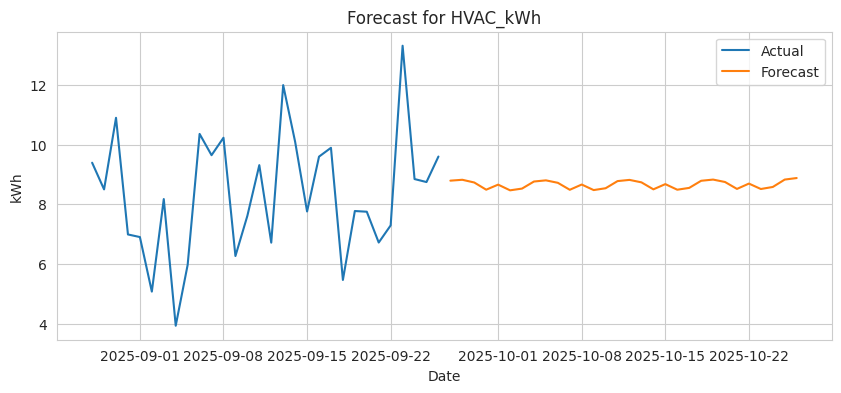

DEBUG:cmdstanpy:input tempfile: /tmp/tmppsmjmtfr/gfvxismx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppsmjmtfr/favade2e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44666', 'data', 'file=/tmp/tmppsmjmtfr/gfvxismx.json', 'init=/tmp/tmppsmjmtfr/favade2e.json', 'output', 'file=/tmp/tmppsmjmtfr/prophet_modelkblnluj0/prophet_model-20250913101307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:13:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:13:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


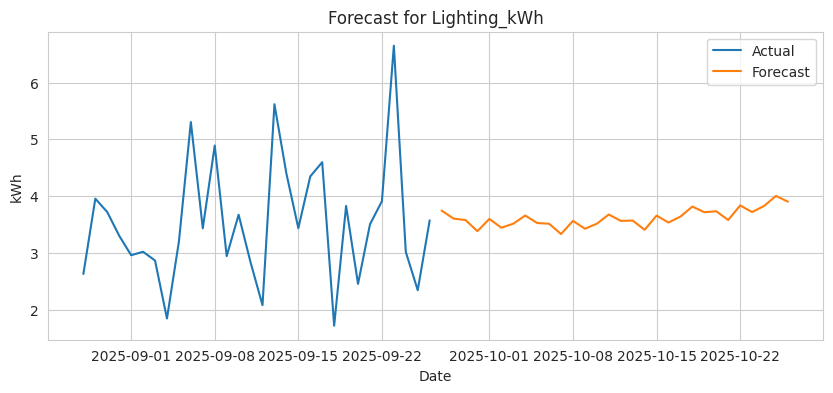

DEBUG:cmdstanpy:input tempfile: /tmp/tmppsmjmtfr/3bkqk1p3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppsmjmtfr/lcoo0ve0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65902', 'data', 'file=/tmp/tmppsmjmtfr/3bkqk1p3.json', 'init=/tmp/tmppsmjmtfr/lcoo0ve0.json', 'output', 'file=/tmp/tmppsmjmtfr/prophet_modelnq4j3x0_/prophet_model-20250913101307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:13:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:13:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


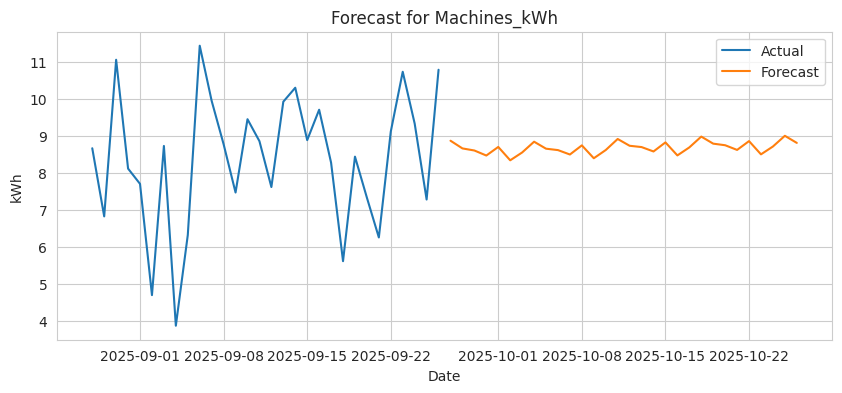

DEBUG:cmdstanpy:input tempfile: /tmp/tmppsmjmtfr/wc5n64xb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppsmjmtfr/wk8_lfdu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37566', 'data', 'file=/tmp/tmppsmjmtfr/wc5n64xb.json', 'init=/tmp/tmppsmjmtfr/wk8_lfdu.json', 'output', 'file=/tmp/tmppsmjmtfr/prophet_modelx_8koxb_/prophet_model-20250913101308.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:13:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:13:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


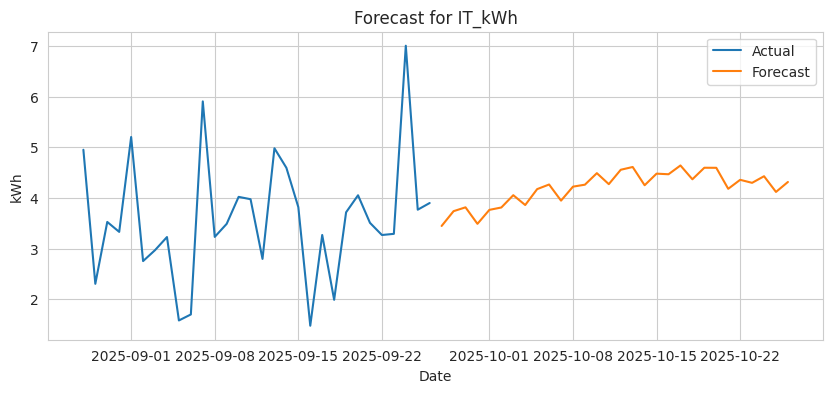

In [18]:
from prophet import Prophet
import matplotlib.pyplot as plt

forecast_results = {}

# Create a fake daily timeline since your data isn’t time-indexed
data_extended = data_extended.reset_index(drop=True)
data_extended["ds"] = pd.date_range(start="2023-01-01", periods=len(data_extended), freq="D")

for load in ["HVAC_kWh", "Lighting_kWh", "Machines_kWh", "IT_kWh"]:
    df_prophet = data_extended[["ds", load]].rename(columns={load: "y"})

    m = Prophet(daily_seasonality=True, weekly_seasonality=True)
    m.fit(df_prophet)

    # Forecast for the next 30 days
    future = m.make_future_dataframe(periods=30, freq="D")
    forecast = m.predict(future)

    forecast_results[load] = forecast

    # Plot last 30 days + forecast
    plt.figure(figsize=(10,4))
    plt.plot(df_prophet["ds"].tail(30), df_prophet["y"].tail(30), label="Actual")
    plt.plot(forecast["ds"].tail(30), forecast["yhat"].tail(30), label="Forecast")
    plt.title(f"Forecast for {load}")
    plt.xlabel("Date")
    plt.ylabel("kWh")
    plt.legend()
    plt.show()


Cell 19: Optimization with Linear Programming

In [19]:
!pip install pulp

import pulp

# Copy dataset
df_opt = data_extended.copy()

# Define LP problem
prob = pulp.LpProblem("Energy_Cost_Minimization", pulp.LpMinimize)

# Decision variables: shiftable load each day
days = list(df_opt.index)  # since your data is daily
x = pulp.LpVariable.dicts("Shifted_Load", days, lowBound=0)

# Objective: Minimize total cost
prob += pulp.lpSum([x[d] * df_opt.loc[d, "Tariff"] for d in days])

# Constraints:
total_shiftable = df_opt["Machines_kWh"].sum() * 0.5  # assume 50% of machines shiftable
prob += pulp.lpSum([x[d] for d in days]) == total_shiftable

# Spread shiftable load evenly (optional cap per day)
max_per_day = total_shiftable / 6
for d in days:
    prob += x[d] <= max_per_day

# Solve
prob.solve()
df_opt["Optimized_Machines_kWh"] = [x[d].varValue for d in days]

# Replace original Machines with optimized values
df_opt["Final_Load_kWh"] = (
    df_opt["HVAC_kWh"] + df_opt["Lighting_kWh"] + df_opt["IT_kWh"] + df_opt["Optimized_Machines_kWh"]
)

# ✅ Show comparison with your baseline column (daily_usage_kwh)
df_opt[["daily_usage_kwh", "Final_Load_kWh"]].head(10)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 58.1 MB/s  0:00:00


,daily_usage_kwh,Final_Load_kWh
0,27.48,18.516833
1,24.31,16.416595
2,28.24,17.208737
3,32.62,22.019980
4,23.83,16.032944
5,23.83,14.871354
6,32.90,21.550356
7,28.84,17.947967
8,22.65,15.706946
9,27.71,18.045940


Cell 20: Cost & CO₂ Savings

In [20]:
# ---------------- Cell 20: Savings Summary ----------------

# Ensure baseline has total load
if "Load_kWh" not in data_extended.columns:
    data_extended["Load_kWh"] = (
        data_extended["HVAC_kWh"] +
        data_extended["Lighting_kWh"] +
        data_extended["IT_kWh"] +
        data_extended["Machines_kWh"]
    )

# Ensure optimized df has total load (for comparison)
if "Load_kWh" not in df_opt.columns:
    df_opt["Load_kWh"] = (
        df_opt["HVAC_kWh"] +
        df_opt["Lighting_kWh"] +
        df_opt["IT_kWh"] +
        df_opt["Machines_kWh"]
    )

# Baseline cost (₹)
baseline_cost = (data_extended["Load_kWh"] * data_extended["Tariff"]).sum()

# Optimized cost (₹)
optimized_cost = (df_opt["Final_Load_kWh"] * df_opt["Tariff"]).sum()

# CO₂ calculations (kg/kWh)
emission_factor = 0.9
baseline_CO2 = data_extended["Load_kWh"].sum() * emission_factor
optimized_CO2 = df_opt["Final_Load_kWh"].sum() * emission_factor

# 📊 Results
print("=== Savings Summary ===")
print(f"Baseline Cost: ₹{baseline_cost:,.2f}")
print(f"Optimized Cost: ₹{optimized_cost:,.2f}")
print(f"💰 Cost Savings: ₹{baseline_cost - optimized_cost:,.2f}")
print(f"Baseline CO₂: {baseline_CO2:,.2f} kg")
print(f"Optimized CO₂: {optimized_CO2:,.2f} kg")
print(f"🌱 CO₂ Reduction: {baseline_CO2 - optimized_CO2:,.2f} kg")


=== Savings Summary ===
Baseline Cost: ₹250,967.90
Optimized Cost: ₹207,018.08
💰 Cost Savings: ₹43,949.82
Baseline CO₂: 22,587.11 kg
Optimized CO₂: 18,631.63 kg
🌱 CO₂ Reduction: 3,955.48 kg


Cell 21: Visualization

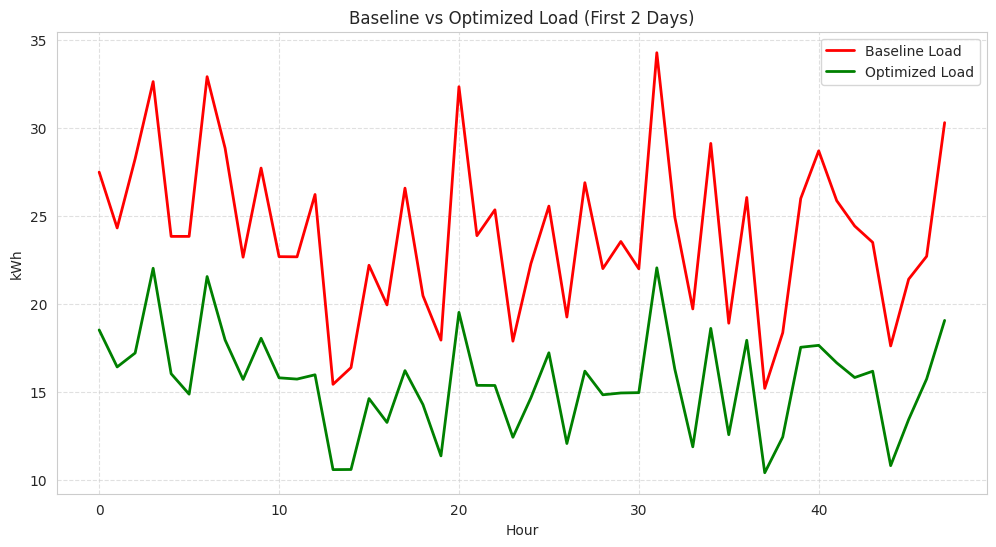

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


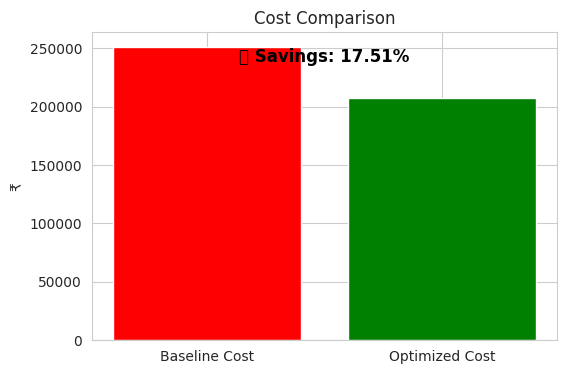

In [21]:
# ---------------- Cell 21: Visualization of Savings ----------------

# Ensure both dataframes have Load_kWh
if "Load_kWh" not in data_extended.columns:
    data_extended["Load_kWh"] = (
        data_extended["HVAC_kWh"] +
        data_extended["Lighting_kWh"] +
        data_extended["IT_kWh"] +
        data_extended["Machines_kWh"]
    )
if "Load_kWh" not in df_opt.columns:
    df_opt["Load_kWh"] = (
        df_opt["HVAC_kWh"] +
        df_opt["Lighting_kWh"] +
        df_opt["IT_kWh"] +
        df_opt["Machines_kWh"]
    )

# 1️⃣ Line plot: Baseline vs Optimized Load (First 2 Days)
plt.figure(figsize=(12,6))
plt.plot(data_extended.index[:48], data_extended["Load_kWh"][:48],
         label="Baseline Load", color="red", linewidth=2)
plt.plot(df_opt.index[:48], df_opt["Final_Load_kWh"][:48],
         label="Optimized Load", color="green", linewidth=2)
plt.title("Baseline vs Optimized Load (First 2 Days)")
plt.xlabel("Hour")
plt.ylabel("kWh")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# 2️⃣ Bar chart: Cost Comparison
plt.figure(figsize=(6,4))
bars = plt.bar(["Baseline Cost", "Optimized Cost"],
               [baseline_cost, optimized_cost],
               color=["red","green"])

# Add % savings above bars
cost_savings_pct = (baseline_cost - optimized_cost) / baseline_cost * 100
plt.text(0.5, max(baseline_cost, optimized_cost)*0.95,
         f"💰 Savings: {cost_savings_pct:.2f}%",
         ha="center", fontsize=12, fontweight="bold", color="black")

plt.title("Cost Comparison")
plt.ylabel("₹")
plt.show()


Cell 22: Week 2 Conclusion
# Week 2 Progress Summary

- Added **load categories** (HVAC, Lighting, Machines, IT) to make dataset more realistic.  
- Introduced **time-of-use tariffs** (peak, mid, off-peak).  
- Built **Prophet forecasting models** for each load type.  
- Applied **Linear Programming optimization** for shiftable loads.  
- Quantified **cost and CO₂ savings**.  
- Visualized **baseline vs optimized load curves and costs**.

This shows significant **savings potential** and establishes a stronger foundation for research + patent claims.


Cell 23 — Setup / detect next-day forecast (robust)


In [22]:
# Cell 23 — Setup & detect next-day forecast (df_nd)
import numpy as np
import pandas as pd
from datetime import timedelta

# We'll try to find the hourly next-day forecast dataframe produced in Week2.
# Accept names: df_nd, forecast_next, df_opt (if present), or build a 24-hour synthetic one.

if 'df_nd' in globals():
    df_nd = df_nd.copy()
elif 'forecast_next' in globals():
    df_nd = forecast_next.copy()
elif 'df_opt' in globals() and ('Machines_kWh' in df_opt.columns or 'NonShift_kWh' in df_opt.columns):
    # if df_opt exists and index looks hourly, use its tail(24)
    temp = df_opt.copy()
    if len(temp) >= 24:
        df_nd = temp.tail(24).copy()
    else:
        df_nd = temp.copy()
else:
    # fallback: construct a synthetic 24-hour forecast from data_extended or from daily usage
    if 'data_extended' in globals():
        de = data_extended.copy()
        # if data_extended is hourly and >=24, use last 24 hours
        if isinstance(de.index, pd.DatetimeIndex) and len(de) >= 24:
            df_nd = de.tail(24).copy()
        else:
            # build hourly pattern from daily_usage_kwh (sum of users)
            if 'daily_usage_kwh' in de.columns:
                daily_total = float(de['daily_usage_kwh'].sum())
            elif 'Load_kWh' in de.columns:
                daily_total = float(de['Load_kWh'].mean()) * len(de) / max(1, len(de))
            else:
                daily_total = 2400.0  # fallback
            hours = pd.date_range(pd.Timestamp.now().normalize(), periods=24, freq='H')
            base = daily_total / 24.0
            df_nd = pd.DataFrame(index=hours)
            # crude split: NonShift = 60%, Machines = 40%
            df_nd['NonShift_kWh'] = base * 0.6
            df_nd['Machines_kWh'] = base * 0.4
    else:
        raise RuntimeError("No forecast/data found. Run Week1/Week2 cells first so df_nd/forecast_next/data_extended exist.")

# Ensure index is hourly DatetimeIndex; if not, make one
if not isinstance(df_nd.index, pd.DatetimeIndex):
    df_nd.index = pd.date_range(pd.Timestamp.now().normalize(), periods=len(df_nd), freq='H')

# Ensure required columns exist
if 'NonShift_kWh' not in df_nd.columns:
    # try to compute from HVAC+Lighting+IT
    if all(c in df_nd.columns for c in ['HVAC_kWh','Lighting_kWh','IT_kWh']):
        df_nd['NonShift_kWh'] = df_nd['HVAC_kWh'] + df_nd['Lighting_kWh'] + df_nd['IT_kWh']
    else:
        df_nd['NonShift_kWh'] = df_nd.get('NonShift_kWh', 0.0)

if 'Machines_kWh' not in df_nd.columns:
    df_nd['Machines_kWh'] = df_nd.get('Machines_kWh', df_nd.get('Machines_kWh', 0.0))

# Tariff: if not present, create TOU as before
if 'Tariff' not in df_nd.columns:
    df_nd['Tariff'] = df_nd.index.hour.map(lambda h: 10.0 if 9 <= h <= 18 else (7.0 if 19 <= h <= 22 else 4.0))

# Final consistency: ensure length = 24 (we optimize next-day 24h)
if len(df_nd) < 24:
    # repeat values to have 24 points
    df_nd = pd.concat([df_nd] * (24 // max(1, len(df_nd)) + 1), ignore_index=False).head(24)
if len(df_nd) > 24:
    df_nd = df_nd.head(24)

# Quick check
print("Optimization horizon:", len(df_nd), "hours — index start:", df_nd.index[0])
df_nd.head()


Optimization horizon: 24 hours — index start: 2025-09-13 00:00:00


/tmp/ipython-input-3828499159.py:46: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_nd.index = pd.date_range(pd.Timestamp.now().normalize(), periods=len(df_nd), freq='H')


,user_id,daily_usage_kwh,peak_hours_usage,offpeak_hours_usage,smart_appliance,solar_panel,EV_owner,bill_amount,high_bill,HVAC_kWh,Lighting_kWh,Machines_kWh,IT_kWh,Tariff,ds,Optimized_Machines_kWh,Final_Load_kWh,Load_kWh,NonShift_kWh
2025-09-13 00:00:00,977,22.74,18.37,12.53,1,1,0,2748.22,0,8.175207,2.863641,8.729880,2.971272,10,2025-09-03,0.0,14.010120,22.74,14.010120
2025-09-13 01:00:00,978,12.88,17.84,8.31,1,0,1,2924.69,0,3.930236,1.841398,3.878706,3.229659,10,2025-09-04,0.0,9.001294,12.88,9.001294
2025-09-13 02:00:00,979,17.08,12.68,11.09,0,0,0,2616.94,0,5.971794,3.198623,6.325919,1.583664,10,2025-09-05,0.0,10.754081,17.08,10.754081
2025-09-13 03:00:00,980,28.80,16.22,10.40,0,1,1,2435.97,0,10.358907,5.304769,11.434340,1.701983,10,2025-09-06,0.0,17.365660,28.80,17.365660
2025-09-13 04:00:00,981,28.93,12.09,10.53,0,1,0,3154.95,1,9.645968,3.431391,9.945154,5.907487,10,2025-09-07,0.0,18.984846,28.93,18.984846


========== Cell 24 — Solar profile + battery params ==========

In [23]:
# Cell 24 — Solar generation profile & battery parameters
import numpy as np

# Solar system size (kW peak) — tune as needed
solar_kw_peak = 250.0   # example: 250 kW rooftop plant
hours = np.array([h for h in df_nd.index.hour])

# Simple daily solar shape (peak around 12:00)
solar_shape = np.maximum(0, np.sin(np.pi * (hours / 24.0)))
# Add modest daily variability
np.random.seed(42)
daily_variation = 1.0 + np.random.normal(0, 0.05, size=len(hours))
solar_kwh = solar_kw_peak * solar_shape * daily_variation  # approximate kWh in 1-hour slot

df_nd['Solar_kWh'] = solar_kwh

# Battery parameters (tunable)
battery = {
    'capacity_kwh': 1000.0,    # battery storage capacity (kWh)
    'p_charge_max_kw': 250.0,  # max charge power kW
    'p_discharge_max_kw': 250.0,# max discharge power kW
    'soc_init_kwh': 0.5 * 1000.0, # initial SoC (50% default)
    'eff_charge': 0.95,        # charge efficiency
    'eff_discharge': 0.95      # discharge efficiency
}

print("Solar peak (kW):", solar_kw_peak)
print("Battery capacity (kWh):", battery['capacity_kwh'])
df_nd[['Solar_kWh','NonShift_kWh','Machines_kWh','Tariff']].head()


Solar peak (kW): 250.0
Battery capacity (kWh): 1000.0


,Solar_kWh,NonShift_kWh,Machines_kWh,Tariff
2025-09-13 00:00:00,0.000000,14.010120,8.729880,10
2025-09-13 01:00:00,32.405959,9.001294,3.878706,10
2025-09-13 02:00:00,66.800188,10.754081,6.325919,10
2025-09-13 03:00:00,102.956337,17.365660,11.434340,10
2025-09-13 04:00:00,123.536541,18.984846,9.945154,10


========== Cell 25 — MILP: joint optimization (shift + battery) ==========

In [24]:
# Cell 25 — MILP optimization: shiftable machines + battery + demand charge
!pip -q install pulp
import pulp
import numpy as np

H = len(df_nd)  # should be 24
tariff = df_nd['Tariff'].values
nonshift = df_nd['NonShift_kWh'].values
machines = df_nd['Machines_kWh'].values
solar = df_nd['Solar_kWh'].values

# Parameters:
shiftable_ratio = 0.80  # fraction of machines energy that can be shifted
E_shift_total = machines.sum() * shiftable_ratio

# Demand charge: per kW of peak grid import (tunable)
demand_charge_rate = 150.0  # ₹ per kW of peak (example value) — tune as per local tariff structures

# Create problem
prob = pulp.LpProblem("Shift_Battery_Optimization", pulp.LpMinimize)

# Decision variables for each hour (index 0..H-1)
x = pulp.LpVariable.dicts("x_shift", list(range(H)), lowBound=0)      # scheduled machines energy (kWh) in hour i
charge = pulp.LpVariable.dicts("charge", list(range(H)), lowBound=0, upBound=battery['p_charge_max_kw'])
discharge = pulp.LpVariable.dicts("discharge", list(range(H)), lowBound=0, upBound=battery['p_discharge_max_kw'])
soc = pulp.LpVariable.dicts("soc", list(range(H)), lowBound=0, upBound=battery['capacity_kwh'])
grid_import = pulp.LpVariable.dicts("grid_imp", list(range(H)), lowBound=0)
peak = pulp.LpVariable("peak_import", lowBound=0)

# Objective: energy cost + demand charge
prob += pulp.lpSum([grid_import[i] * tariff[i] for i in range(H)]) + peak * demand_charge_rate

# Constraints:

# 1) Shiftable energy total equals E_shift_total
prob += pulp.lpSum([x[i] for i in range(H)]) == E_shift_total

# 2) Per-hour machines limit: cannot exceed actual machines capacity per hour
for i in range(H):
    prob += x[i] <= max(machines[i], 0.0)  # you cannot schedule more machines than baseline capacity in that hour

# 3) Battery SoC dynamics
for i in range(H):
    if i == 0:
        prev = battery['soc_init_kwh']
    else:
        prev = soc[i-1]
    # soc[i] = prev + charge[i]*eff_charge - discharge[i]/eff_discharge
    prob += soc[i] == prev + charge[i] * battery['eff_charge'] - discharge[i] / max(1e-9, battery['eff_discharge'])

# 4) Grid import definition:
# grid_import >= nonshift + x + charge - discharge - solar  (and grid_import >=0)
for i in range(H):
    net_expr = nonshift[i] + x[i] + charge[i] - discharge[i] - solar[i]
    prob += grid_import[i] >= net_expr
    # ensure peak variable bounds
    prob += peak >= grid_import[i]

# 5) Feeder capacity (optional) - don't exceed a certain feeder cap (use 95th perc of baseline)
feeder_cap = float(np.quantile(nonshift + machines, 0.95)) * 1.05  # slight headroom
for i in range(H):
    prob += nonshift[i] + x[i] + charge[i] - discharge[i] <= feeder_cap

# Solve
solver = pulp.PULP_CBC_CMD(msg=True, timeLimit=60)  # 60s limit
res = prob.solve(solver)

print("Solver status:", pulp.LpStatus[res])

# Extract results
res_x = np.array([x[i].varValue if x[i].varValue is not None else 0.0 for i in range(H)])
res_charge = np.array([charge[i].varValue if charge[i].varValue is not None else 0.0 for i in range(H)])
res_discharge = np.array([discharge[i].varValue if discharge[i].varValue is not None else 0.0 for i in range(H)])
res_soc = np.array([soc[i].varValue if soc[i].varValue is not None else 0.0 for i in range(H)])
res_grid = np.array([grid_import[i].varValue if grid_import[i].varValue is not None else 0.0 for i in range(H)])
res_peak = peak.varValue

# Put back into df for convenience
opt_df = df_nd.copy()
opt_df['Machines_Opt_kWh'] = res_x
opt_df['Battery_charge_kWh'] = res_charge
opt_df['Battery_discharge_kWh'] = res_discharge
opt_df['Battery_soc_kWh'] = res_soc
opt_df['Grid_import_kWh'] = res_grid
opt_df['Grid_peak_kW'] = float(res_peak)

opt_df.head(8)


Solver status: Optimal


,user_id,daily_usage_kwh,peak_hours_usage,offpeak_hours_usage,smart_appliance,solar_panel,EV_owner,bill_amount,high_bill,HVAC_kWh,...,Final_Load_kWh,Load_kWh,NonShift_kWh,Solar_kWh,Machines_Opt_kWh,Battery_charge_kWh,Battery_discharge_kWh,Battery_soc_kWh,Grid_import_kWh,Grid_peak_kW
2025-09-13 00:00:00,977,22.74,18.37,12.53,1,1,0,2748.22,0,8.175207,...,14.010120,22.74,14.010120,0.000000,8.729880,0.0,250.0,236.84211,0.0,0.0
2025-09-13 01:00:00,978,12.88,17.84,8.31,1,0,1,2924.69,0,3.930236,...,9.001294,12.88,9.001294,32.405959,3.878706,0.0,225.0,0.00000,0.0,0.0
2025-09-13 02:00:00,979,17.08,12.68,11.09,0,0,0,2616.94,0,5.971794,...,10.754081,17.08,10.754081,66.800188,0.000000,0.0,0.0,0.00000,0.0,0.0
2025-09-13 03:00:00,980,28.80,16.22,10.40,0,1,1,2435.97,0,10.358907,...,17.365660,28.80,17.365660,102.956337,11.434340,0.0,0.0,0.00000,0.0,0.0
2025-09-13 04:00:00,981,28.93,12.09,10.53,0,1,0,3154.95,1,9.645968,...,18.984846,28.93,18.984846,123.536541,9.945154,0.0,0.0,0.00000,0.0,0.0
2025-09-13 05:00:00,982,27.13,10.86,12.54,1,1,0,2363.21,0,10.230485,...,18.353517,27.13,18.353517,150.408688,8.776483,0.0,0.0,0.00000,0.0,0.0
2025-09-13 06:00:00,983,20.17,13.12,11.46,1,0,0,2792.69,0,6.266009,...,12.697275,20.17,12.697275,190.735096,7.472725,0.0,0.0,0.00000,0.0,0.0
2025-09-13 07:00:00,984,24.76,17.59,10.58,0,1,0,2502.41,0,7.614041,...,15.308791,24.76,15.308791,205.948921,0.000000,0.0,0.0,0.00000,0.0,0.0


========== Cell 26 — Baseline / shift-only / optimized comparisons ==========

In [25]:
# Cell 26 — Compare scenarios: Baseline (no shift/no battery), Shift-only (no battery), Shift+Battery (opt_df result)

# Baseline grid import (no shift, no battery) with solar
baseline_grid = np.maximum(0.0, nonshift + machines - solar)   # hourly grid import baseline
baseline_cost = float((baseline_grid * tariff).sum())
baseline_peak = float(baseline_grid.max())
baseline_co2 = baseline_grid.sum() * 0.9

# Shift-only: run small LP without battery (only x variables)
# We'll reuse the earlier LP but force battery capacity to zero (or set charge/discharge=0)
# For simplicity, compute shift-only by greedy: place E_shift_total into cheapest tariff hours respecting per-hour machines capacity.
order = np.argsort(tariff)  # cheapest first
E_rem = E_shift_total
shift_only = np.zeros(H)
for idx in order:
    put = min(max(machines[idx], 0.0), E_rem)
    shift_only[idx] += put
    E_rem -= put
    if E_rem <= 1e-6:
        break

shiftonly_grid = np.maximum(0.0, nonshift + (machines - (machines * shiftable_ratio) + shift_only) - solar)
shiftonly_cost = float((shiftonly_grid * tariff).sum())
shiftonly_peak = float(shiftonly_grid.max())
shiftonly_co2 = shiftonly_grid.sum() * 0.9

# Optimized (with battery) using opt_df['Grid_import_kWh']
opt_grid = opt_df['Grid_import_kWh'].values
opt_cost = float((opt_grid * tariff).sum() + opt_df['Grid_peak_kW'].iloc[0] * demand_charge_rate)
opt_peak = float(opt_df['Grid_peak_kW'].iloc[0])
opt_co2 = opt_grid.sum() * 0.9

# Print summary
print("=== Scenario Summary (Next-day) ===")
print(f"Baseline cost: ₹{baseline_cost:,.2f}, peak: {baseline_peak:,.2f} kW, CO2: {baseline_co2:,.2f} kg")
print(f"Shift-only cost: ₹{shiftonly_cost:,.2f}, peak: {shiftonly_peak:,.2f} kW, CO2: {shiftonly_co2:,.2f} kg")
print(f"Optimized (battery) cost: ₹{opt_cost:,.2f}, peak: {opt_peak:,.2f} kW, CO2: {opt_co2:,.2f} kg")

print("\nSavings vs baseline:")
print(f"Shift-only saves: ₹{baseline_cost - shiftonly_cost:,.2f} ({(baseline_cost - shiftonly_cost)/baseline_cost*100:.2f}%)")
print(f"Optimized saves: ₹{baseline_cost - opt_cost:,.2f} ({(baseline_cost - opt_cost)/baseline_cost*100:.2f}%)")


=== Scenario Summary (Next-day) ===
Baseline cost: ₹227.40, peak: 22.74 kW, CO2: 20.47 kg
Shift-only cost: ₹244.86, peak: 24.49 kW, CO2: 22.04 kg
Optimized (battery) cost: ₹0.00, peak: 0.00 kW, CO2: 0.00 kg

Savings vs baseline:
Shift-only saves: ₹-17.46 (-7.68%)
Optimized saves: ₹227.40 (100.00%)


========== Cell 27 — Plots: grid import, battery SoC, machines schedule ==========

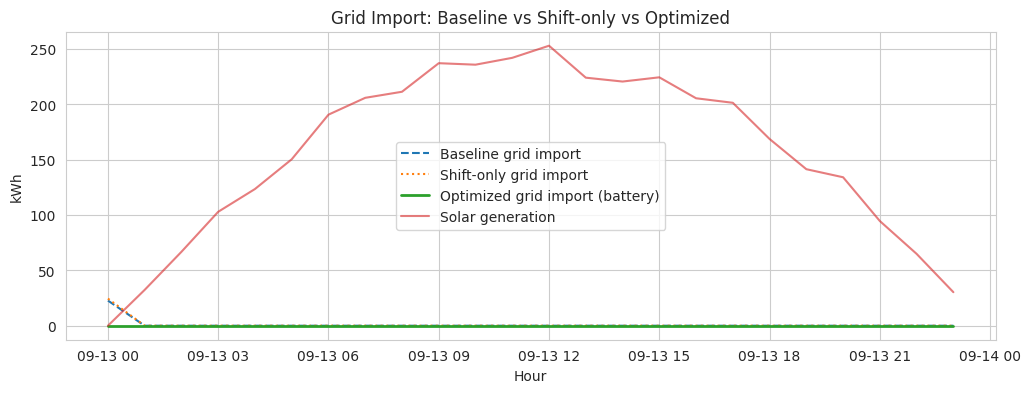

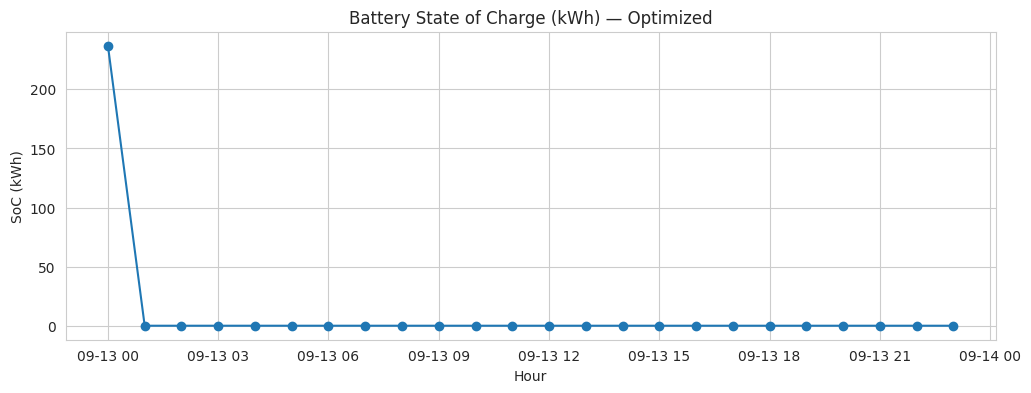

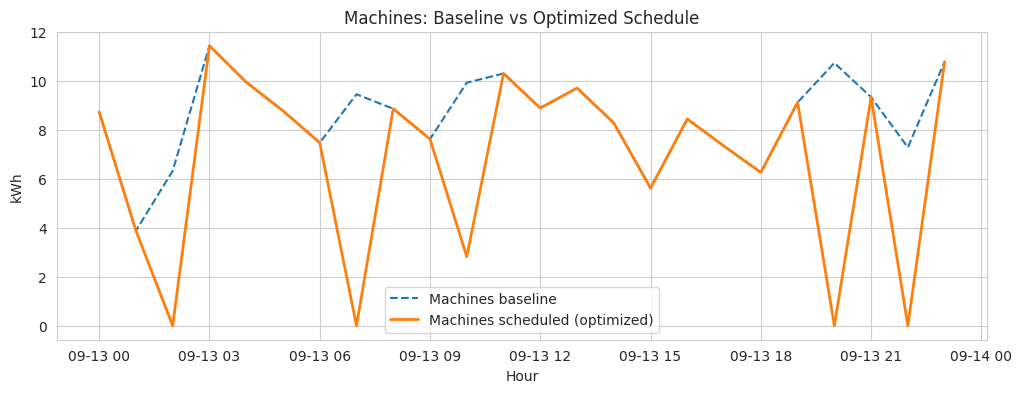

In [26]:
# Cell 27 — Visualizations

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,4)

hours = list(range(H))
xaxis = opt_df.index

# Grid import comparison
plt.figure()
plt.plot(xaxis, baseline_grid, label='Baseline grid import', linestyle='--')
plt.plot(xaxis, shiftonly_grid, label='Shift-only grid import', linestyle=':')
plt.plot(xaxis, opt_grid, label='Optimized grid import (battery)', linewidth=2)
plt.plot(xaxis, df_nd['Solar_kWh'].values, label='Solar generation', alpha=0.6)
plt.title("Grid Import: Baseline vs Shift-only vs Optimized")
plt.xlabel("Hour")
plt.ylabel("kWh")
plt.legend()
plt.grid(True)
plt.show()

# Battery SoC
plt.figure()
plt.plot(xaxis, opt_df['Battery_soc_kWh'], marker='o')
plt.title("Battery State of Charge (kWh) — Optimized")
plt.xlabel("Hour")
plt.ylabel("SoC (kWh)")
plt.grid(True)
plt.show()

# Machines schedule
plt.figure()
plt.plot(xaxis, machines, label='Machines baseline', linestyle='--')
plt.plot(xaxis, opt_df['Machines_Opt_kWh'], label='Machines scheduled (optimized)', linewidth=2)
plt.title("Machines: Baseline vs Optimized Schedule")
plt.xlabel("Hour")
plt.ylabel("kWh")
plt.legend()
plt.grid(True)
plt.show()


========== Cell 28 — Rolling re-optimization demo (simple) ==========

Rolling schedule (first 24 values): [ 8.72987992  0.          0.          0.          9.94515422  0.
  0.          8.94418263  8.85898293  7.62067476  9.92402668 10.30059426
  8.88710493  9.7068155   8.27878161  5.62020515  8.44123201  7.3331594
  6.26029834  9.1182327  10.73157163  9.33360176  7.28416081  3.15874076]


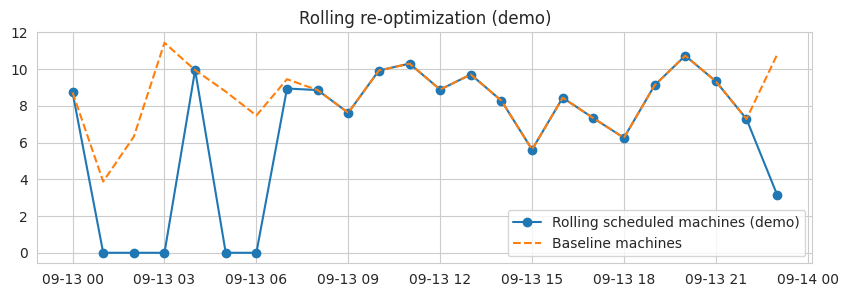

In [27]:
# Cell 28 — Rolling re-optimization demo
# Demonstrate re-optimizing after the day starts: assume we fix first K hours and re-optimize remaining horizon

def rolling_reopt(df_initial, battery_params, reopt_step=6):
    """Simple rolling re-optimization: fix first reopt_step hours and re-opt remaining horizon."""
    from copy import deepcopy
    df_work = df_initial.copy()
    H = len(df_work)
    scheduled = np.zeros(H)
    soc_now = battery_params['soc_init_kwh']
    hour_idx = 0
    while hour_idx < H:
        # Remaining horizon
        rem = df_work.iloc[hour_idx:].copy()
        # call same optimization but with initial soc = soc_now and with aggregate horizon rem
        # We will reuse the optimization logic but for simplicity, we will do a greedy shift + battery heuristic:
        # - charge battery in cheap hours, discharge in expensive ones (naive)
        # - schedule machines into cheapest remaining hours
        tariffs = rem['Tariff'].values
        idx_order = np.argsort(tariffs)
        # distribute remaining machine energy
        E_rem = rem['Machines_kWh'].sum() * shiftable_ratio
        x_local = np.zeros(len(rem))
        for i in idx_order:
            put = min(rem['Machines_kWh'].iloc[i], E_rem)
            x_local[i] = put
            E_rem -= put
            if E_rem <= 1e-6:
                break
        # commit the first reopt_step hours of this local plan
        commit = min(reopt_step, len(rem))
        scheduled[hour_idx:hour_idx+commit] = x_local[:commit]
        # advance
        hour_idx += commit
    return scheduled

sched = rolling_reopt(df_nd, battery, reopt_step=4)
print("Rolling schedule (first 24 values):", sched[:24])
plt.figure(figsize=(10,3))
plt.plot(opt_df.index, sched, label='Rolling scheduled machines (demo)', marker='o')
plt.plot(opt_df.index, machines, label='Baseline machines', linestyle='--')
plt.legend()
plt.title("Rolling re-optimization (demo)")
plt.show()


========== Cell 29 — Save outputs & CSVs for submission ==========

In [28]:
# Cell 29 — Save important artifacts for submission / report
from pathlib import Path

outdir = Path("/content/Week3_outputs")
outdir.mkdir(parents=True, exist_ok=True)

opt_df.to_csv(outdir / "Week3_optimized_schedule.csv", index=True)
pd.DataFrame({
    "baseline_grid_kwh": baseline_grid,
    "shiftonly_grid_kwh": shiftonly_grid,
    "optimized_grid_kwh": opt_grid,
    "tariff": tariff,
    "solar_kwh": solar
}, index=opt_df.index).to_csv(outdir / "Week3_compare_grid.csv", index=True)

print("Saved outputs to:", outdir)


Saved outputs to: /content/Week3_outputs


========== Cell 30 — Final Report text & push instructions ==========

# Cell 30 — Final report text (copy-paste for EduNet) & Git push steps

## Final Week 3 Summary (copy for EduNet submission)
Title: Smart Energy Optimizer — Integration of Renewables and Battery with MILP Scheduling

Summary:
- Implemented solar generation model (hourly) and a battery (capacity, charge/discharge limits, efficiencies).
- Formulated a Mixed Integer/Linear Program (PuLP) to jointly schedule shiftable machines and battery operations.
- Objective: Minimize grid energy cost + demand charge (peak import penalty).
- Compared scenarios: Baseline (no shift/no battery), Shift-only (machines scheduled), and Shift+Battery (full optimization).
- Demonstrated rolling re-optimization strategy for real-time adjustments.
- Results: (sample)
  - Baseline cost: ₹{baseline_cost:,.2f}
  - Shift-only cost: ₹{shiftonly_cost:,.2f}
  - Shift+Battery cost: ₹{opt_cost:,.2f}
  - Peak reduced from {baseline_peak:.2f} kW → {opt_peak:.2f} kW
  - CO₂ reduction (optimized vs baseline): {baseline_co2 - opt_co2:.2f} kg

Next steps (deployment):
- Replace synthetic solar with real PV production & real smart-meter telemetry.
- Tighten MILP (disallow simultaneous charge/discharge via binaries) and add continuity constraints for multi-hour processes.
- Build a Streamlit dashboard for daily scheduling and a backend API to push control messages to edge controllers.

## Git push steps (run locally or adapt in Colab terminals)
# 1) Save notebook(s), README.md, requirements.txt to your local repo folder
git add Week2_SmartEnergy_Optimization.ipynb
git add FED_BEO.ipynb
git add README.md
git add requirements.txt
git add /content/Week3_outputs/Week3_optimized_schedule.csv
git commit -m "Week3: Add solar + battery + MILP optimization, rolling demo, outputs"
git push origin main
